In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Filepath to shared drive
# filepath = '/content/drive/MyDrive/AANDA/'

# Filepath to your own drive folder and files if it doesn't work
filepath = "/content/drive/MyDrive/ANNDA/Lab4/lab4_code/"

# Filepath to your own drive folder and files if it doesn't work
#filepath = "/content/drive/MyDrive/TMAIM/DD2437-ANNDA/AANDA/Lab4/lab4_code/"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Given code files

##util.py

In [ ]:
def sigmoid(support):

    """
    Sigmoid activation function that finds probabilities to turn ON each unit.

    Args:
      support: shape is (size of mini-batch, size of layer)
    Returns:
      on_probabilities: shape is (size of mini-batch, size of layer)
    """

    on_probabilities = 1./(1.+np.exp(-support))
    return on_probabilities

def softmax(support):

    """
    Softmax activation function that finds probabilities of each category

    Args:
      support: shape is (size of mini-batch, number of categories)
    Returns:
      probabilities: shape is (size of mini-batch, number of categories)
    """

    expsup = np.exp(support-np.max(support,axis=1)[:,None])
    return expsup / np.sum(expsup,axis=1)[:,None]

def sample_binary(on_probabilities):

    """
    Sample activations ON=1 (OFF=0) from probabilities sigmoid probabilities

    Args:
      support: shape is (size of mini-batch, size of layer)
    Returns:
      activations: shape is (size of mini-batch, size of layer)
    """

    activations = 1. * ( on_probabilities >= np.random.random_sample(size=on_probabilities.shape) )
    return activations

def sample_categorical(probabilities):

    """
    Sample one-hot activations from categorical probabilities

    Args:
      support: shape is (size of mini-batch, number of categories)
    Returns:
      activations: shape is (size of mini-batch, number of categories)
    """

    cumsum = np.cumsum(probabilities,axis=1)
    rand = np.random.random_sample(size=probabilities.shape[0])[:,None]
    activations = np.zeros(probabilities.shape)
    activations[range(probabilities.shape[0]),np.argmax((cumsum >= rand),axis=1)] = 1
    return activations

def load_idxfile(filename):

    """
    Load idx file format. For more information : http://yann.lecun.com/exdb/mnist/
    """
    import struct

    with open(filename,'rb') as _file:
        if ord(_file.read(1)) != 0 or ord(_file.read(1)) != 0 :
           raise Exception('Invalid idx file: unexpected magic number!')
        dtype,ndim = ord(_file.read(1)),ord(_file.read(1))
        shape = [struct.unpack(">I", _file.read(4))[0] for _ in range(ndim)]
        data = np.fromfile(_file, dtype=np.dtype(np.uint8).newbyteorder('>')).reshape(shape)
    return data

def read_mnist(dim=[28,28],n_train=60000,n_test=1000):

    """
    Read mnist train and test data. Images are normalized to be in range [0,1]. Labels are one-hot coded.
    """

    train_imgs = load_idxfile(filepath+"train-images-idx3-ubyte")
    train_imgs = train_imgs / 255.
    train_imgs = train_imgs.reshape(-1,dim[0]*dim[1])

    train_lbls = load_idxfile(filepath+"train-labels-idx1-ubyte")
    train_lbls_1hot = np.zeros((len(train_lbls),10),dtype=np.float32)
    train_lbls_1hot[range(len(train_lbls)),train_lbls] = 1.

    test_imgs = load_idxfile(filepath+"t10k-images-idx3-ubyte")
    test_imgs = test_imgs / 255.
    test_imgs = test_imgs.reshape(-1,dim[0]*dim[1])

    test_lbls = load_idxfile(filepath+"t10k-labels-idx1-ubyte")
    test_lbls_1hot = np.zeros((len(test_lbls),10),dtype=np.float32)
    test_lbls_1hot[range(len(test_lbls)),test_lbls] = 1.

    return train_imgs[:n_train],train_lbls_1hot[:n_train],test_imgs[:n_test],test_lbls_1hot[:n_test]

def viz_rf(weights,it,grid):

    """
    Visualize receptive fields and save
    """
    fig, axs = plt.subplots(grid[0],grid[1],figsize=(grid[1],grid[0]))#,constrained_layout=True)
    plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0,hspace=0)
    imax = abs(weights).max()
    for x in range(grid[0]):
        for y in range(grid[1]):
            axs[x,y].set_xticks([]);
            axs[x,y].set_yticks([]);
            axs[x,y].imshow(weights[:,:,y+grid[1]*x], cmap="bwr", vmin=-imax, vmax=imax, interpolation=None)
    plt.savefig(filepath+"rf.iter%06d.png"%it)
    plt.close('all')

def stitch_video(fig,imgs):
    """
    Stitches a list of images and returns a animation object
    """
    import matplotlib.animation as animation

    return animation.ArtistAnimation(fig, imgs, interval=100, blit=True, repeat=False)


##rbm.py

In [ ]:
class RestrictedBoltzmannMachine():
    '''
    For more details : A Practical Guide to Training Restricted Boltzmann Machines https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf
    '''
    def __init__(self, ndim_visible, ndim_hidden, is_bottom=False, image_size=[28,28], is_top=False, n_labels=10, batch_size=10):

        """
        Args:
          ndim_visible: Number of units in visible layer.
          ndim_hidden: Number of units in hidden layer.
          is_bottom: True only if this rbm is at the bottom of the stack in a deep belief net. Used to interpret visible layer as image data with dimensions "image_size".
          image_size: Image dimension for visible layer.
          is_top: True only if this rbm is at the top of stack in deep beleif net. Used to interpret visible layer as concatenated with "n_label" unit of label data at the end.
          n_label: Number of label categories.
          batch_size: Size of mini-batch.
        """

        self.ndim_visible = ndim_visible

        self.ndim_hidden = ndim_hidden

        self.is_bottom = is_bottom

        if is_bottom : self.image_size = image_size

        self.is_top = is_top

        if is_top : self.n_labels = 10

        self.batch_size = batch_size

        self.delta_bias_v = 0

        self.delta_weight_vh = 0

        self.delta_bias_h = 0

        self.bias_v = np.random.normal(loc=0.0, scale=0.01, size=(self.ndim_visible))

        self.weight_vh = np.random.normal(loc=0.0, scale=0.01, size=(self.ndim_visible,self.ndim_hidden))

        self.bias_h = np.random.normal(loc=0.0, scale=0.01, size=(self.ndim_hidden))

        self.delta_weight_v_to_h = 0

        self.delta_weight_h_to_v = 0

        self.weight_v_to_h = None

        self.weight_h_to_v = None

        self.learning_rate = 0.01

        self.momentum = 0.7

        self.print_period = 400

        self.rf = { # receptive-fields. Only applicable when visible layer is input data
            "period" : 400, # iteration period to visualize
            "grid" : [5,5], # size of the grid
            "ids" : np.random.randint(0,self.ndim_hidden,25) # pick some random hidden units
            }

        return


    def cd1(self,visible_trainset, n_iterations=10000):

        """Contrastive Divergence with k=1 full alternating Gibbs sampling

        Args:
          visible_trainset: training data for this rbm, shape is (size of training set, size of visible layer)
          n_iterations: number of iterations of learning (each iteration learns a mini-batch)
        """

        print ("learning CD1")

        n_samples = visible_trainset.shape[0]

        self.rec_loss = []
        self.delta_weight_vh_norm = []
        self.delta_bias_v_norm = []
        self.delta_bias_h_norm = []


        for it in range(n_iterations):

	        # [TODO TASK 4.1] run k=1 alternating Gibbs sampling : v_0 -> h_0 ->  v_1 -> h_1.
            # you may need to use the inference functions 'get_h_given_v' and 'get_v_given_h'.
            # note that inference methods returns both probabilities and activations (samples from probabilities) and you may have to decide when to use what.
            ################# DONE #######################

            #Gets the minibatch
            if ((it+1)*self.batch_size)%n_samples - (it*self.batch_size)%n_samples < 0:
                visible_minibatch=visible_trainset[(it*self.batch_size)%n_samples : n_samples]
            else:
                visible_minibatch=visible_trainset[(it*self.batch_size)%n_samples : ((it+1)*self.batch_size)%n_samples]

            #Perform k=1 Gibbs sampling on the minibatch                #I don't know where we should use proabilities or samples???????
            v_0=visible_minibatch
            h_p0, h_0 = self.get_h_given_v(v_0)
            v_1, v_1s = self.get_v_given_h(h_0)
            h_1, h_1s = self.get_h_given_v(v_1)


            # [TODO TASK 4.1] update the parameters using function 'update_params'
            ############### DONE ##################

            self.update_params(v_0, h_0, v_1, h_1)

            # visualize once in a while when visible layer is input images

            if it % self.rf["period"] == 0 and self.is_bottom:

                viz_rf(weights=self.weight_vh[:,self.rf["ids"]].reshape((self.image_size[0],self.image_size[1],-1)), it=it, grid=self.rf["grid"])

            # print progress

            if it % self.print_period == 0 :
                reconstruction=self.get_v_given_h(self.get_h_given_v(visible_trainset)[1])
                loss = np.mean(np.square(visible_trainset - reconstruction))
                self.rec_loss.append(loss)

                #print ("iteration=%7d recon_loss=%4.4f"%(it, np.linalg.norm(visible_trainset - reconstruction)))
                print ("iteration=%7d recon_loss=%4.4f"%(it, loss))

            self.delta_weight_vh_norm.append(np.linalg.norm(self.delta_weight_vh))
            self.delta_bias_v_norm.append(np.linalg.norm(self.delta_bias_v))
            self.delta_bias_h_norm.append(np.linalg.norm(self.delta_bias_h))


    def update_params(self,v_0,h_0,v_k,h_k):

        """Update the weight and bias parameters.

        You could also add weight decay and momentum for weight updates.

        Args:
           v_0: activities or probabilities of visible layer (data to the rbm)
           h_0: activities or probabilities of hidden layer
           v_k: activities or probabilities of visible layer
           h_k: activities or probabilities of hidden layer
           all args have shape (size of mini-batch, size of respective layer)
        """

        # [TODO TASK 4.1] get the gradients from the arguments (replace the 0s below) and update the weight and bias parameters
        ################ DONE ###################


        self.delta_bias_v = self.learning_rate*np.mean(v_0-v_k, axis=0) + self.momentum*self.delta_bias_v
        self.delta_weight_vh = self.learning_rate*(v_0.T @ h_0 - v_k.T @ h_k)/self.batch_size + self.momentum*self.delta_weight_vh
        self.delta_bias_h = self.learning_rate*np.mean(h_0-h_k, axis=0) + self.momentum*self.delta_bias_h

        self.bias_v += self.delta_bias_v
        self.weight_vh += self.delta_weight_vh
        self.bias_h += self.delta_bias_h

        return

    def get_h_given_v(self,visible_minibatch):

        """Compute probabilities p(h|v) and activations h ~ p(h|v)

        Uses undirected weight "weight_vh" and bias "bias_h"

        Args:
           visible_minibatch: shape is (size of mini-batch, size of visible layer)
        Returns:
           tuple ( p(h|v) , h)
           both are shaped (size of mini-batch, size of hidden layer)
        """

        assert self.weight_vh is not None

        n_samples = visible_minibatch.shape[0]

        # [TODO TASK 4.1] compute probabilities and activations (samples from probabilities) of hidden layer (replace the zeros below)
        ################## DONE ######################

        probabilities=sigmoid(self.bias_h.reshape((self.ndim_hidden,1)) + (visible_minibatch @ self.weight_vh).T).T
        random=np.random.rand(n_samples, self.ndim_hidden)
        activations=probabilities-random
        activations=np.ceil(activations)

        return probabilities, activations


    def get_v_given_h(self,hidden_minibatch):

        """Compute probabilities p(v|h) and activations v ~ p(v|h)

        Uses undirected weight "weight_vh" and bias "bias_v"

        Args:
           hidden_minibatch: shape is (size of mini-batch, size of hidden layer)
        Returns:
           tuple ( p(v|h) , v)
           both are shaped (size of mini-batch, size of visible layer)
        """

        assert self.weight_vh is not None

        n_samples = hidden_minibatch.shape[0]

        if self.is_top:

            """
            Here visible layer has both data and labels. Compute total input for each unit (identical for both cases), \
            and split into two parts, something like support[:, :-self.n_labels] and support[:, -self.n_labels:]. \
            Then, for both parts, use the appropriate activation function to get probabilities and a sampling method \
            to get activities. The probabilities as well as activities can then be concatenated back into a normal visible layer.
            """

            # [TODO TASK 4.1] compute probabilities and activations (samples from probabilities) of visible layer (replace the pass below). \
            # Note that this section can also be postponed until TASK 4.2, since in this task, stand-alone RBMs do not contain labels in visible layer.

            support=(self.bias_v.reshape((self.ndim_visible,1)) + (self.weight_vh @ hidden_minibatch.T)).T

            dataprob=sigmoid(support[:, :-self.n_labels])
            labelprob=softmax(support[:, -self.n_labels:])

            dataact=sample_binary(dataprob)
            labelact=sample_categorical(labelprob)

            probabilities=np.concatenate((dataprob,labelprob),axis=1)
            activations=np.concatenate((dataact,labelact),axis=1)

        else:

            # [TODO TASK 4.1] compute probabilities and activations (samples from probabilities) of visible layer (replace the pass and zeros below)
            ############################ DONE ##############################

            probabilities=sigmoid(self.bias_v.reshape((self.ndim_visible,1)) + (self.weight_vh @ hidden_minibatch.T)).T
            random=np.random.rand(n_samples, self.ndim_visible)
            activations=probabilities-random
            activations=np.ceil(activations)

        return probabilities, activations



    """ rbm as a belief layer : the functions below do not have to be changed until running a deep belief net """



    def untwine_weights(self):

        self.weight_v_to_h = np.copy( self.weight_vh )
        self.weight_h_to_v = np.copy( np.transpose(self.weight_vh) )
        self.weight_vh = None

    def get_h_given_v_dir(self,visible_minibatch):

        """Compute probabilities p(h|v) and activations h ~ p(h|v)

        Uses directed weight "weight_v_to_h" and bias "bias_h"

        Args:
           visible_minibatch: shape is (size of mini-batch, size of visible layer)
        Returns:
           tuple ( p(h|v) , h)
           both are shaped (size of mini-batch, size of hidden layer)
        """

        assert self.weight_v_to_h is not None

        n_samples = visible_minibatch.shape[0]

        # [TODO TASK 4.2] perform same computation as the function 'get_h_given_v' but with directed connections (replace the zeros below)
        ############### DONE ################

        probabilities=sigmoid(self.bias_h.reshape((self.ndim_hidden,1)) + (visible_minibatch @ self.weight_v_to_h).T).T
        activations=sample_binary(probabilities)

        return probabilities, activations


    def get_v_given_h_dir(self,hidden_minibatch):


        """Compute probabilities p(v|h) and activations v ~ p(v|h)

        Uses directed weight "weight_h_to_v" and bias "bias_v"

        Args:
           hidden_minibatch: shape is (size of mini-batch, size of hidden layer)
        Returns:
           tuple ( p(v|h) , v)
           both are shaped (size of mini-batch, size of visible layer)
        """

        assert self.weight_h_to_v is not None

        n_samples = hidden_minibatch.shape[0]

        if self.is_top:

            """
            Here visible layer has both data and labels. Compute total input for each unit (identical for both cases), \
            and split into two parts, something like support[:, :-self.n_labels] and support[:, -self.n_labels:]. \
            Then, for both parts, use the appropriate activation function to get probabilities and a sampling method \
            to get activities. The probabilities as well as activities can then be concatenated back into a normal visible layer.
            """

            # [TODO TASK 4.2] Note that even though this function performs same computation as 'get_v_given_h' but with directed connections,
            # this case should never be executed : when the RBM is a part of a DBN and is at the top, it will have not have directed connections.
            # Appropriate code here is to raise an error (replace pass below)
            ############### DONE #################

            raise RuntimeError("'get_v_given_h_dir' should never be called from the top layer!")

        else:

            # [TODO TASK 4.2] performs same computaton as the function 'get_v_given_h' but with directed connections (replace the pass and zeros below)
            ################ DONE #################

            probabilities=sigmoid(self.bias_v.reshape((self.ndim_visible,1)) + (hidden_minibatch @ self.weight_h_to_v).T).T
            activations=sample_binary(probabilities)

        return probabilities, activations

    def update_generate_params(self,inps,trgs,preds):

        """Update generative weight "weight_h_to_v" and bias "bias_v"

        Args:
           inps: activities or probabilities of input unit
           trgs: activities or probabilities of output unit (target)
           preds: activities or probabilities of output unit (prediction)
           all args have shape (size of mini-batch, size of respective layer)
        """

        # [TODO TASK 4.3] find the gradients from the arguments (replace the 0s below) and update the weight and bias parameters.

        self.delta_weight_h_to_v += 0
        self.delta_bias_v += 0

        self.weight_h_to_v += self.delta_weight_h_to_v
        self.bias_v += self.delta_bias_v

        return

    def update_recognize_params(self,inps,trgs,preds):

        """Update recognition weight "weight_v_to_h" and bias "bias_h"

        Args:
           inps: activities or probabilities of input unit
           trgs: activities or probabilities of output unit (target)
           preds: activities or probabilities of output unit (prediction)
           all args have shape (size of mini-batch, size of respective layer)
        """

        # [TODO TASK 4.3] find the gradients from the arguments (replace the 0s below) and update the weight and bias parameters.

        self.delta_weight_v_to_h += 0
        self.delta_bias_h += 0

        self.weight_v_to_h += self.delta_weight_v_to_h
        self.bias_h += self.delta_bias_h

        return


In [ ]:
def visualize_recontructions(im, id_im, image_size = [28,28]):
    _, h = rbm.get_h_given_v(im)
    _, reconstruction = rbm.get_v_given_h(h)

    plt.imshow(im[id_im].reshape((image_size[0], image_size[1])))
    plt.grid(False)
    plt.axis('off')
    plt.show()

    plt.imshow(reconstruction[id_im].reshape((image_size[0], image_size[1])))
    plt.grid(False)
    plt.axis('off')
    plt.show()

##dbn.py

In [ ]:
class DeepBeliefNet():

    '''
    For more details : Hinton, Osindero, Teh (2006). A fast learning algorithm for deep belief nets. https://www.cs.toronto.edu/~hinton/absps/fastnc.pdf

    network          : [top] <---> [pen] ---> [hid] ---> [vis]
                               `-> [lbl]
    lbl : label
    top : top
    pen : penultimate
    hid : hidden
    vis : visible
    '''

    def __init__(self, sizes, image_size, n_labels, batch_size, load_if_possible):

        """
        Args:
          sizes: Dictionary of layer names and dimensions
          image_size: Image dimension of data
          n_labels: Number of label categories
          batch_size: Size of mini-batch
        """

        self.rbm_stack = {

            'vis--hid' : RestrictedBoltzmannMachine(ndim_visible=sizes["vis"], ndim_hidden=sizes["hid"],
                                                    is_bottom=True, image_size=image_size, batch_size=batch_size),

            'hid--pen' : RestrictedBoltzmannMachine(ndim_visible=sizes["hid"], ndim_hidden=sizes["pen"], batch_size=batch_size),

            'pen+lbl--top' : RestrictedBoltzmannMachine(ndim_visible=sizes["pen"]+sizes["lbl"], ndim_hidden=sizes["top"],
                                                        is_top=True, n_labels=n_labels, batch_size=batch_size)
        }

        self.sizes = sizes

        self.image_size = image_size

        self.batch_size = batch_size

        self.n_gibbs_recog = 15

        self.n_gibbs_gener = 200

        self.n_gibbs_wakesleep = 5

        self.print_period = 2000

        self.load_if_possible = load_if_possible

        return

    def recognize(self,true_img,true_lbl):

        """Recognize/Classify the data into label categories and calculate the accuracy

        Args:
          true_imgs: visible data shaped (number of samples, size of visible layer)
          true_lbl: true labels shaped (number of samples, size of label layer). Used only for calculating accuracy, not driving the net
        """

        n_samples = true_img.shape[0]

        vis = true_img # visible layer gets the image data

        lbl = np.ones(true_lbl.shape)/10. # start the net by telling you know nothing about labels

        # [TODO TASK 4.2] fix the image data in the visible layer and drive the network bottom to top. In the top RBM, run alternating Gibbs sampling \
        # and read out the labels (replace pass below and 'predicted_lbl' to your predicted labels).
        # NOTE : inferring entire train/test set may require too much compute memory (depends on your system). In that case, divide into mini-batches.
        #################### DONE ######################

        for rbm_name in ['vis--hid', 'hid--pen']:   #go bottom to top
            rbm = self.rbm_stack[rbm_name]
            vis,_ =rbm.get_h_given_v_dir(vis)

        rbm = self.rbm_stack["pen+lbl--top"]
        vis_lbl=np.concatenate((vis,lbl), axis=1)
        for _ in range(self.n_gibbs_recog):
            hid,_=rbm.get_h_given_v(vis_lbl)
            vis_lbl,_=rbm.get_v_given_h(hid)

        predicted_lbl = vis_lbl[:,-rbm.n_labels:]

        print ("accuracy = %.2f%%"%(100.*np.mean(np.argmax(predicted_lbl,axis=1)==np.argmax(true_lbl,axis=1))))

        return predicted_lbl

    def generate(self,true_lbl,name):

        """Generate data from labels

        Args:
          true_lbl: true labels shaped (number of samples, size of label layer)
          name: string used for saving a video of generated visible activations
        """
        n_sample = true_lbl.shape[0]

        records = []
        fig,ax = plt.subplots(1,1,figsize=(3,3))
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
        ax.set_xticks([]); ax.set_yticks([])

        lbl = true_lbl

        # [TODO TASK 4.2] fix the label in the label layer and run alternating Gibbs sampling in the top RBM. From the top RBM, drive the network \
        # top to the bottom visible layer (replace 'vis' from random to your generated visible layer).

        vis=np.random.randint(0,2,(n_sample,self.sizes["vis"])) #random images

        for rbm_name in ['vis--hid', 'hid--pen']:   #go bottom to top
            rbm = self.rbm_stack[rbm_name]
            vis,_ =rbm.get_h_given_v_dir(vis)

        vis=np.concatenate((vis[:,0:self.sizes["pen"]],true_lbl),axis=1)

        for _ in range(self.n_gibbs_gener):     # gibbs sampling
            hid,_=self.rbm_stack['pen+lbl--top'].get_h_given_v(vis)
            vis,_=self.rbm_stack['pen+lbl--top'].get_v_given_h(hid)
            vis=np.concatenate((vis[:,0:self.sizes["pen"]],true_lbl),axis=1)   #clamp true labels

        hid=vis[:,0:self.sizes["pen"]]

        for rbm_name in [ 'hid--pen','vis--hid' ]:   #go top to bottom
            rbm = self.rbm_stack[rbm_name]
            _,hid =rbm.get_v_given_h_dir(hid)

        vis=hid
        records.append( [ ax.imshow(vis.reshape(self.image_size), cmap="bwr", vmin=0, vmax=1, animated=True, interpolation=None) ] )


        anim = stitch_video(fig,records).save(filepath+"%s.generate%d.mp4"%(name,np.argmax(true_lbl)))

        return vis.reshape(self.image_size)

    def train_greedylayerwise(self, vis_trainset, lbl_trainset, n_iterations):

        """
        Greedy layer-wise training by stacking RBMs. This method first tries to load previous saved parameters of the entire RBM stack.
        If not found, learns layer-by-layer (which needs to be completed) .
        Notice that once you stack more layers on top of a RBM, the weights are permanently untwined.

        Args:
          vis_trainset: visible data shaped (size of training set, size of visible layer)
          lbl_trainset: label data shaped (size of training set, size of label layer)
          n_iterations: number of iterations of learning (each iteration learns a mini-batch)
        """

        try :

            if (not self.load_if_possible):
                raise IOError()

            self.loadfromfile_rbm(loc="trained_rbm",name="vis--hid")
            self.rbm_stack["vis--hid"].untwine_weights()

            self.loadfromfile_rbm(loc="trained_rbm",name="hid--pen")
            self.rbm_stack["hid--pen"].untwine_weights()

            self.loadfromfile_rbm(loc="trained_rbm",name="pen+lbl--top")

        except IOError :

            # [TODO TASK 4.2] use CD-1 to train all RBMs greedily
            ########### DONE #############

            print("training vis--hid")

            #CD-1 training for vis--hid
            self.rbm_stack["vis--hid"].cd1(vis_trainset, n_iterations)

            self.savetofile_rbm(loc="trained_rbm",name="vis--hid")
            self.rbm_stack["vis--hid"].untwine_weights()

            print("training hid--pen")

            #CD-1 training for hid--pen
            transformed_trainset=self.rbm_stack["vis--hid"].get_h_given_v_dir(vis_trainset)[1]
            self.rbm_stack["hid--pen"].cd1(transformed_trainset, n_iterations)

            self.savetofile_rbm(loc="trained_rbm",name="hid--pen")
            self.rbm_stack["hid--pen"].untwine_weights()

            print("training pen+lbl--top")

            #CD-1 training for pen+lbl--top
            transformed_trainset=self.rbm_stack["hid--pen"].get_h_given_v_dir(transformed_trainset)[1]
            transformed_trainset=np.concatenate((transformed_trainset, lbl_trainset), axis=1)       #Adds labels
            self.rbm_stack["pen+lbl--top"].cd1(transformed_trainset, n_iterations)

            self.savetofile_rbm(loc="trained_rbm",name="pen+lbl--top")


        return

    def train_wakesleep_finetune(self, vis_trainset, lbl_trainset, n_iterations):

        """
        Wake-sleep method for learning all the parameters of network.
        First tries to load previous saved parameters of the entire network.

        Args:
          vis_trainset: visible data shaped (size of training set, size of visible layer)
          lbl_trainset: label data shaped (size of training set, size of label layer)
          n_iterations: number of iterations of learning (each iteration learns a mini-batch)
        """

        print ("\ntraining wake-sleep..")

        try :

            self.loadfromfile_dbn(loc="trained_dbn",name="vis--hid")
            self.loadfromfile_dbn(loc="trained_dbn",name="hid--pen")
            self.loadfromfile_rbm(loc="trained_dbn",name="pen+lbl--top")

        except IOError :

            self.n_samples = vis_trainset.shape[0]

            for it in range(n_iterations):

                # [TODO TASK 4.3] wake-phase : drive the network bottom to top using fixing the visible and label data.

                # [TODO TASK 4.3] alternating Gibbs sampling in the top RBM for k='n_gibbs_wakesleep' steps, also store neccessary information for learning this RBM.

                # [TODO TASK 4.3] sleep phase : from the activities in the top RBM, drive the network top to bottom.

                # [TODO TASK 4.3] compute predictions : compute generative predictions from wake-phase activations, and recognize predictions from sleep-phase activations.
                # Note that these predictions will not alter the network activations, we use them only to learn the directed connections.

                # [TODO TASK 4.3] update generative parameters : here you will only use 'update_generate_params' method from rbm class.

                # [TODO TASK 4.3] update parameters of top rbm : here you will only use 'update_params' method from rbm class.

                # [TODO TASK 4.3] update generative parameters : here you will only use 'update_recognize_params' method from rbm class.

                if it % self.print_period == 0 : print ("iteration=%7d"%it)

            self.savetofile_dbn(loc="trained_dbn",name="vis--hid")
            self.savetofile_dbn(loc="trained_dbn",name="hid--pen")
            self.savetofile_rbm(loc="trained_dbn",name="pen+lbl--top")

        return


    def loadfromfile_rbm(self,loc,name):

        self.rbm_stack[name].weight_vh = np.load(filepath+"%s/rbm.%s.weight_vh.npy"%(loc,name))
        self.rbm_stack[name].bias_v    = np.load(filepath+"%s/rbm.%s.bias_v.npy"%(loc,name))
        self.rbm_stack[name].bias_h    = np.load(filepath+"%s/rbm.%s.bias_h.npy"%(loc,name))
        print ("loaded rbm[%s] from %s"%(name,loc))
        return

    def savetofile_rbm(self,loc,name):

        np.save(filepath+"%s/rbm.%s.weight_vh"%(loc,name), self.rbm_stack[name].weight_vh)
        np.save(filepath+"%s/rbm.%s.bias_v"%(loc,name),    self.rbm_stack[name].bias_v)
        np.save(filepath+"%s/rbm.%s.bias_h"%(loc,name),    self.rbm_stack[name].bias_h)
        return

    def loadfromfile_dbn(self,loc,name):

        self.rbm_stack[name].weight_v_to_h = np.load(filepath+"%s/dbn.%s.weight_v_to_h.npy"%(loc,name))
        self.rbm_stack[name].weight_h_to_v = np.load(filepath+"%s/dbn.%s.weight_h_to_v.npy"%(loc,name))
        self.rbm_stack[name].bias_v        = np.load(filepath+"%s/dbn.%s.bias_v.npy"%(loc,name))
        self.rbm_stack[name].bias_h        = np.load(filepath+"%s/dbn.%s.bias_h.npy"%(loc,name))
        print ("loaded rbm[%s] from %s"%(name,loc))
        return

    def savetofile_dbn(self,loc,name):

        np.save(filepath+"%s/dbn.%s.weight_v_to_h"%(loc,name), self.rbm_stack[name].weight_v_to_h)
        np.save(filepath+"%s/dbn.%s.weight_h_to_v"%(loc,name), self.rbm_stack[name].weight_h_to_v)
        np.save(filepath+"%s/dbn.%s.bias_v"%(loc,name),        self.rbm_stack[name].bias_v)
        np.save(filepath+"%s/dbn.%s.bias_h"%(loc,name),        self.rbm_stack[name].bias_h)
        return



##run.py


Starting a Deep Belief Net..
loaded rbm[vis--hid] from trained_rbm
loaded rbm[hid--pen] from trained_rbm
loaded rbm[pen+lbl--top] from trained_rbm


<ipython-input-137-6e6a07b66bcb>:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,1,figsize=(3,3))
<ipython-input-137-6e6a07b66bcb>:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,1,figsize=(3,3))
<ipython-input-137-6e6a07b66bcb>:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warn

'\n\n\n\'\'\' fine-tune wake-sleep training \'\'\'\n\ndbn.train_wakesleep_finetune(vis_trainset=train_imgs, lbl_trainset=train_lbls, n_iterations=10000)\n\ndbn.recognize(train_imgs, train_lbls)\n\ndbn.recognize(test_imgs, test_lbls)\n\nfor digit in range(10):\n    digit_1hot = np.zeros(shape=(1,10))\n    digit_1hot[0,digit] = 1\n    dbn.generate(digit_1hot, name="dbn")\n'

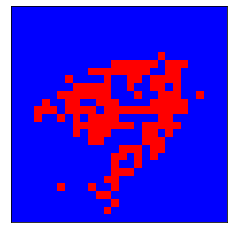

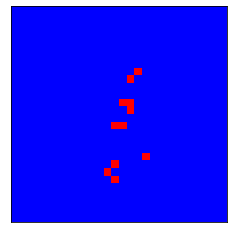

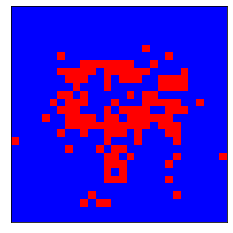

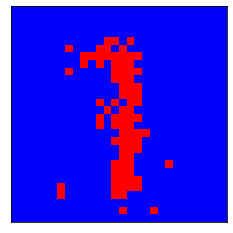

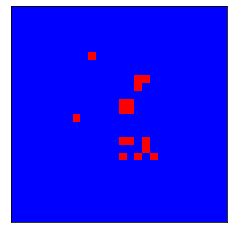

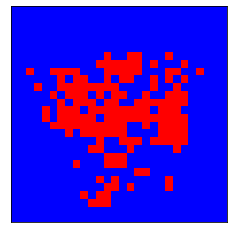

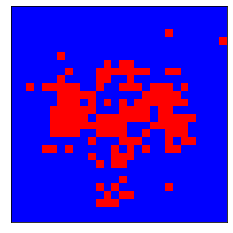

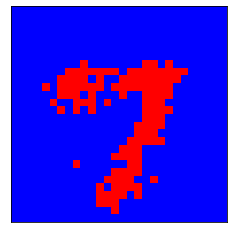

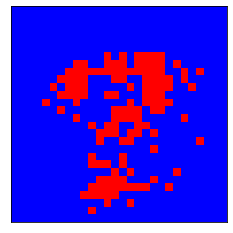

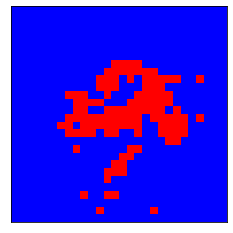

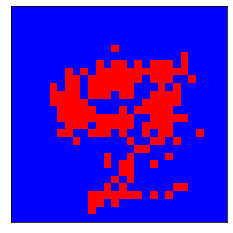

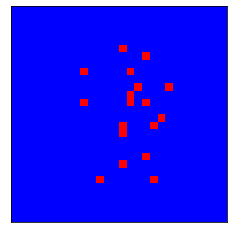

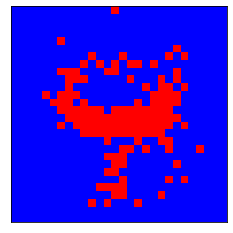

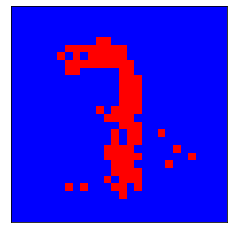

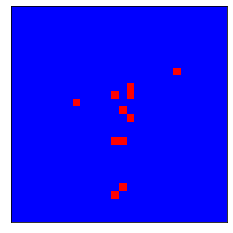

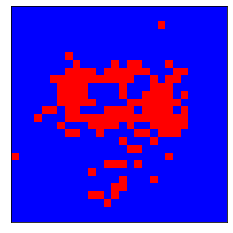

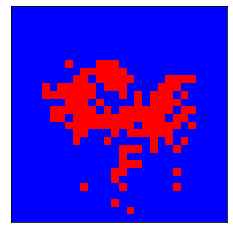

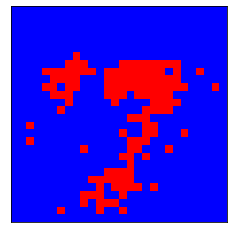

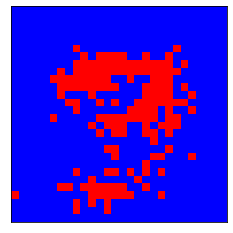

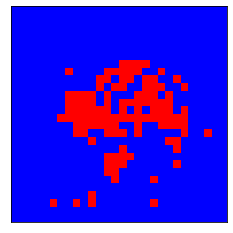

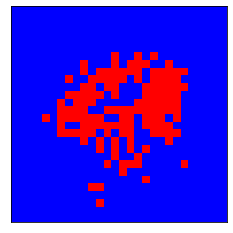

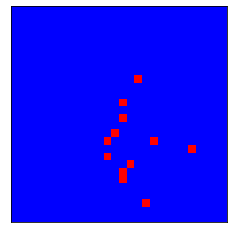

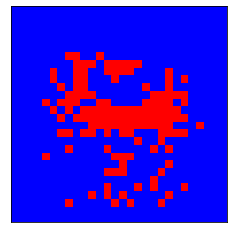

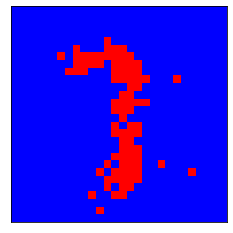

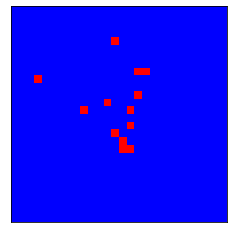

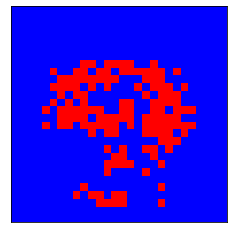

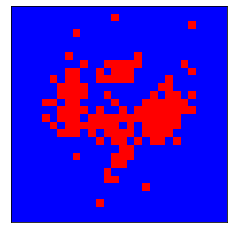

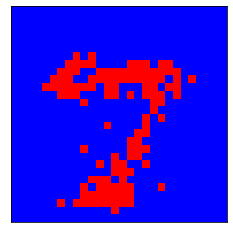

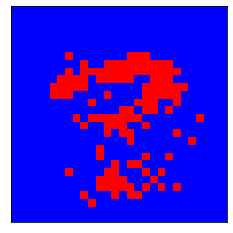

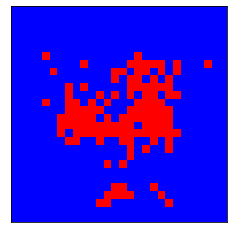

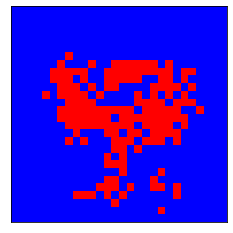

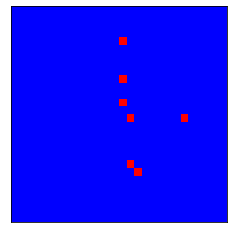

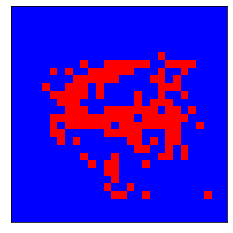

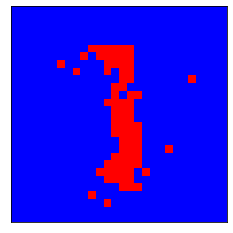

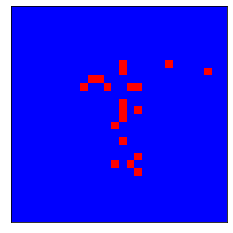

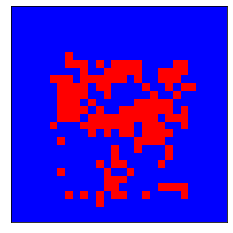

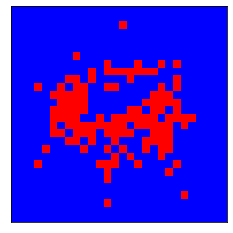

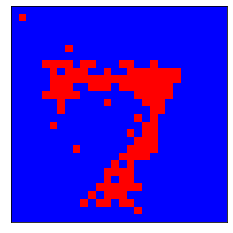

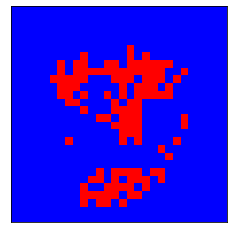

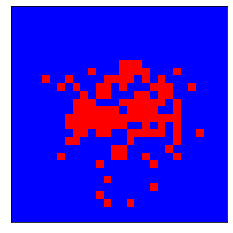

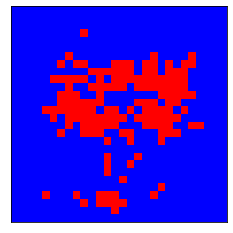

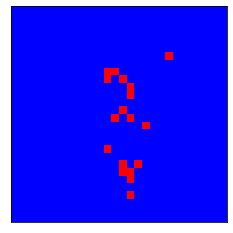

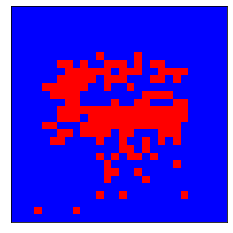

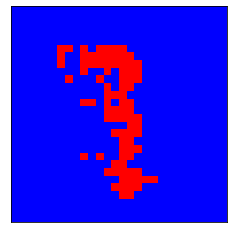

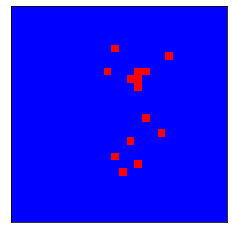

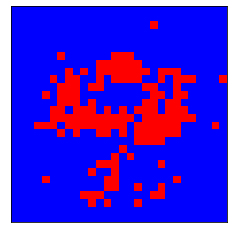

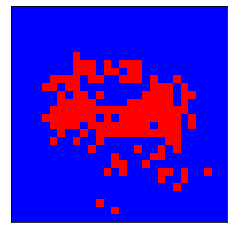

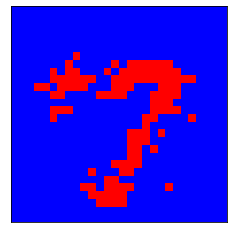

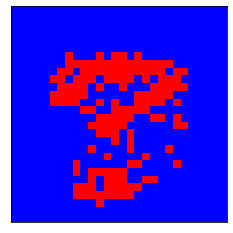

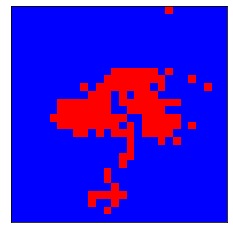

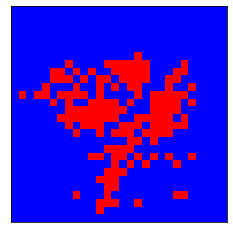

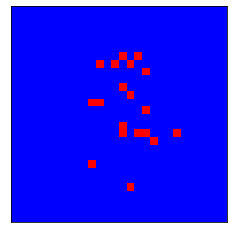

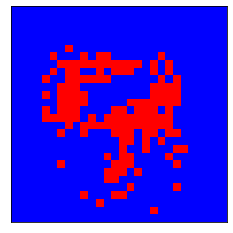

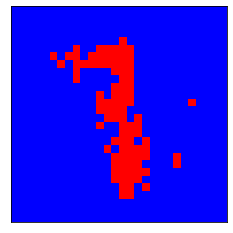

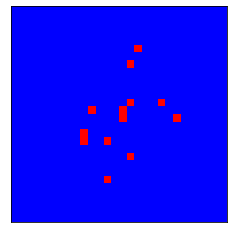

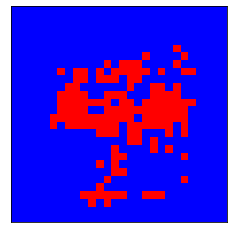

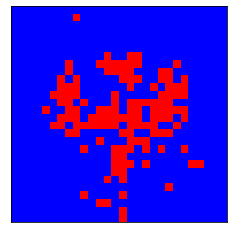

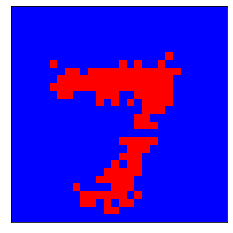

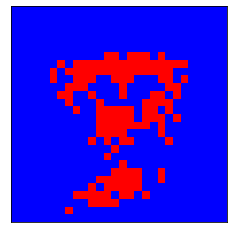

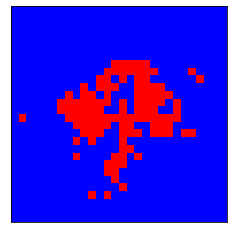

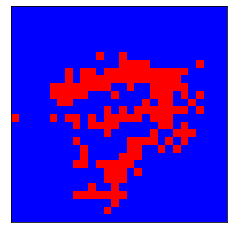

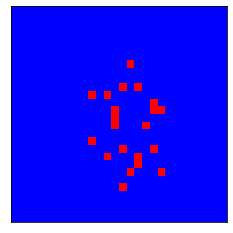

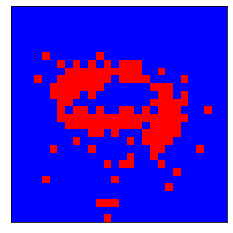

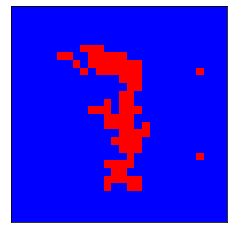

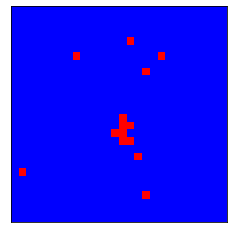

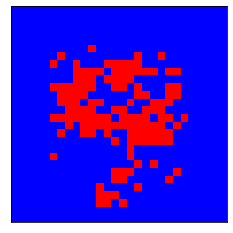

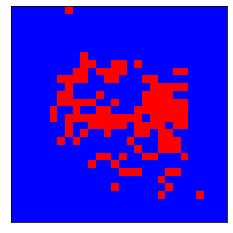

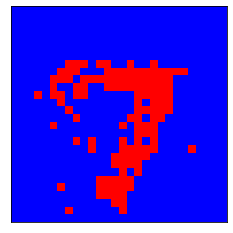

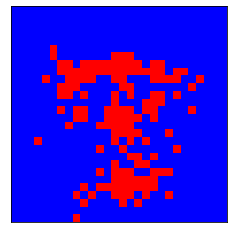

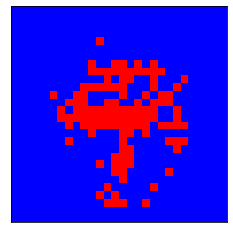

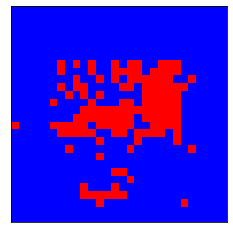

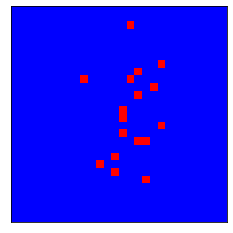

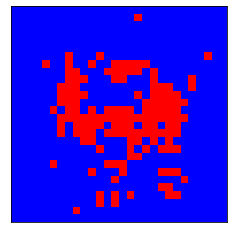

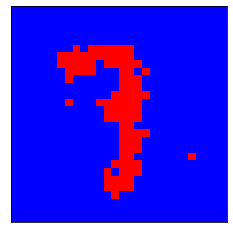

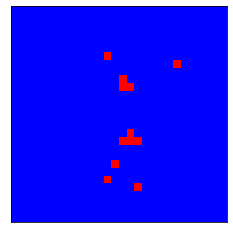

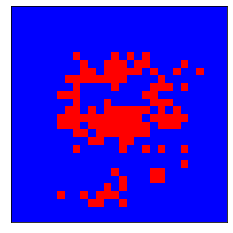

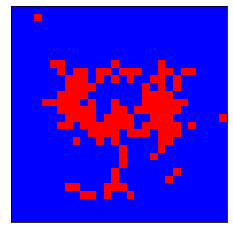

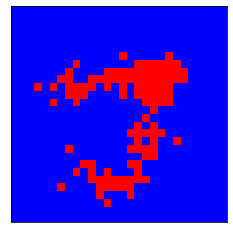

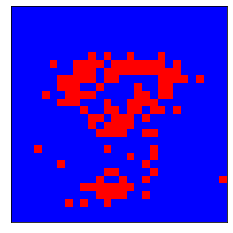

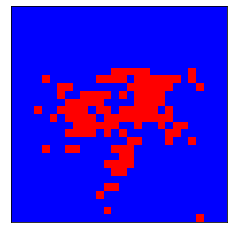

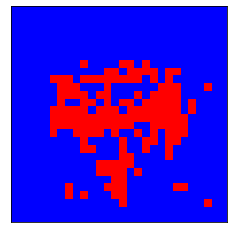

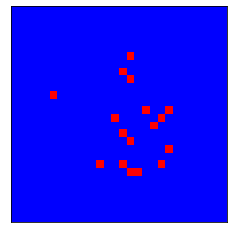

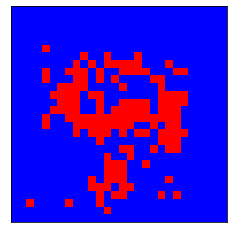

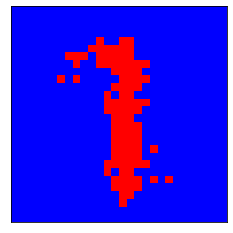

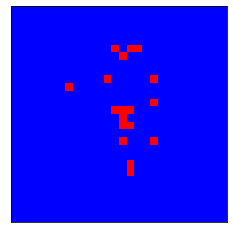

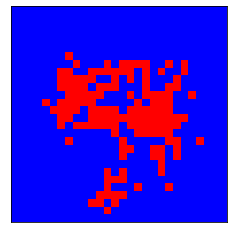

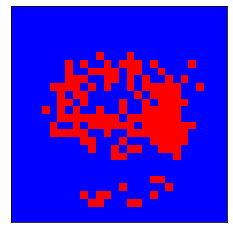

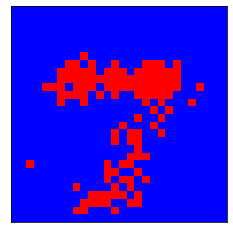

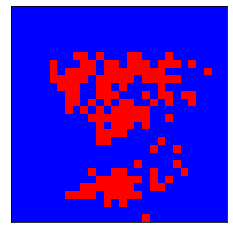

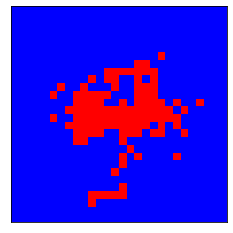

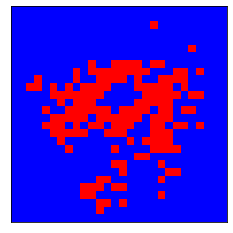

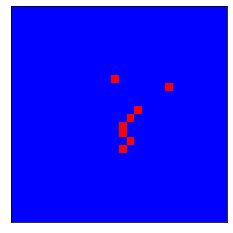

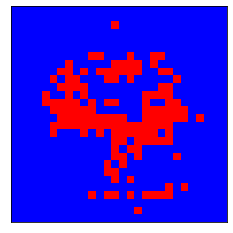

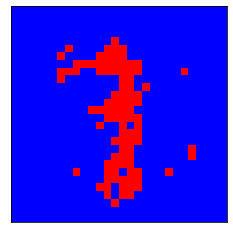

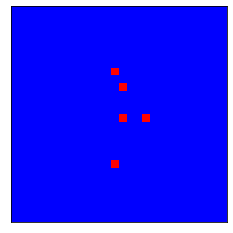

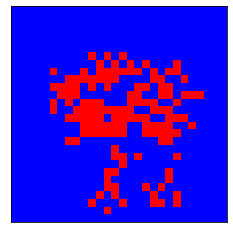

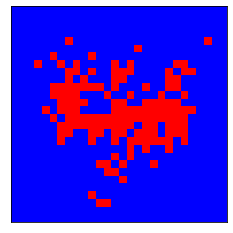

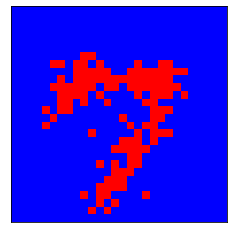

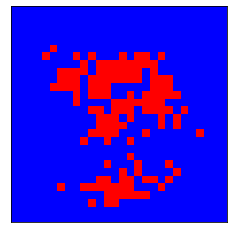

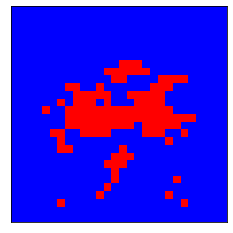

In [ ]:
image_size = [28,28]
train_imgs,train_lbls,test_imgs,test_lbls = read_mnist(dim=image_size, n_train=60000, n_test=10000) #!!!# Reduce number of samples to run dbn faster (orginally 60000, 10000)

''' restricted boltzmann machine '''
"""
print ("\nStarting a Restricted Boltzmann Machine..")

rbm = RestrictedBoltzmannMachine(ndim_visible=image_size[0]*image_size[1],
                                    ndim_hidden=500,
                                    is_bottom=True,
                                    image_size=image_size,
                                    is_top=False,
                                    n_labels=10,
                                    batch_size=20
)

rbm.cd1(visible_trainset=train_imgs, n_iterations=1000)        #!!!# Reduce number of itterations to run faster ()

"""
''' deep- belief net '''

print ("\nStarting a Deep Belief Net..")

dbn = DeepBeliefNet(sizes={"vis":image_size[0]*image_size[1], "hid":500, "pen":500, "top":2000, "lbl":10},
                    image_size=image_size,
                    n_labels=10,
                    batch_size=20,
                    load_if_possible=True  #Forces retraining if false
)

''' greedy layer-wise training '''

dbn.train_greedylayerwise(vis_trainset=train_imgs, lbl_trainset=train_lbls, n_iterations=1000)
"""
pred_lbls_train=dbn.recognize(train_imgs, train_lbls)

pred_lbls_test=dbn.recognize(test_imgs, test_lbls)

for digit in range(10):
    digit_1hot = np.zeros(shape=(100,10))
    digit_1hot[10*digit:10*digit+9,digit] = 1
    dbn.generate(digit_1hot, name="rbms")
"""
im=[]
for i in range(10):
  for digit in range(10):
      digit_1hot = np.zeros(shape=(1,10))
      digit_1hot[0,digit] = 1
      im.append(dbn.generate(digit_1hot, name="dbn"))
"""


''' fine-tune wake-sleep training '''

dbn.train_wakesleep_finetune(vis_trainset=train_imgs, lbl_trainset=train_lbls, n_iterations=10000)

dbn.recognize(train_imgs, train_lbls)

dbn.recognize(test_imgs, test_lbls)

for digit in range(10):
    digit_1hot = np.zeros(shape=(1,10))
    digit_1hot[0,digit] = 1
    dbn.generate(digit_1hot, name="dbn")
"""


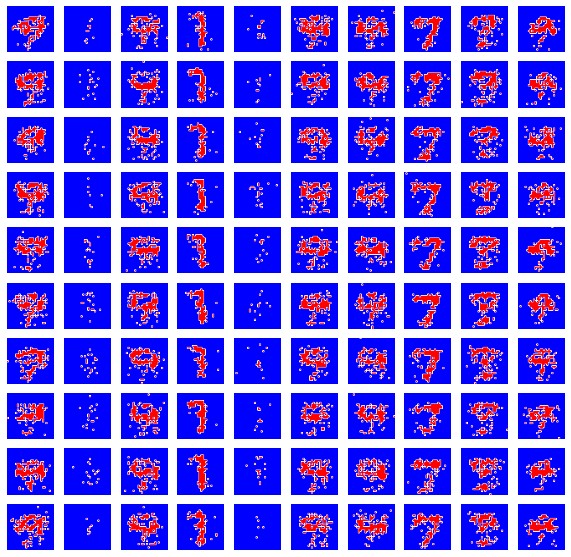

In [ ]:
fig = plt.figure(figsize=(10, 10))
rows = 10
columns = 10
for k in range(len(im)):
  fig.add_subplot(rows, columns, k+1)
  vis=im[k]
  plt.axis('off')
  plt.imshow(vis.reshape(image_size), cmap="bwr", vmin=0, vmax=1, animated=True, interpolation=None)

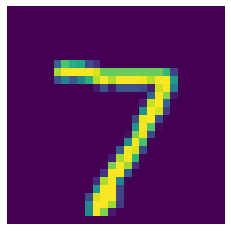

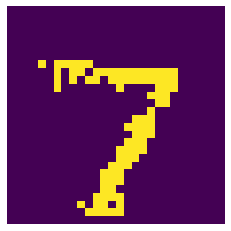

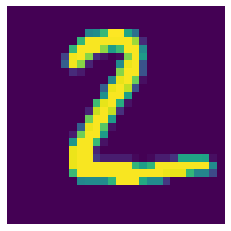

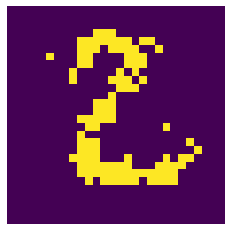

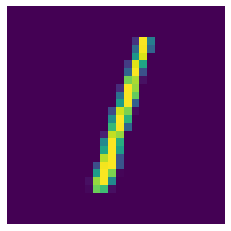

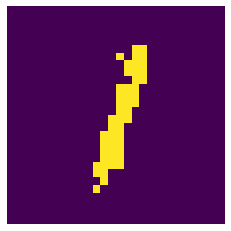

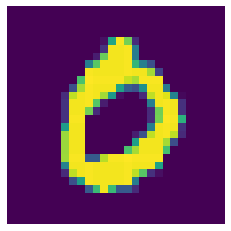

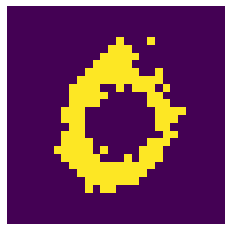

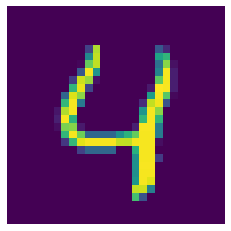

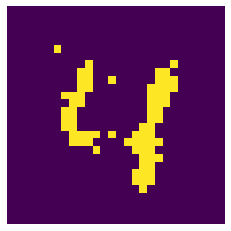

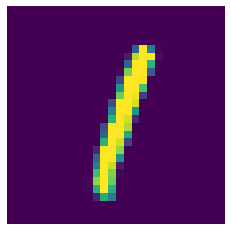

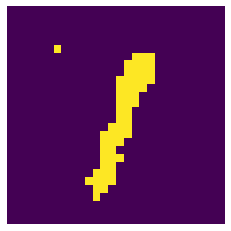

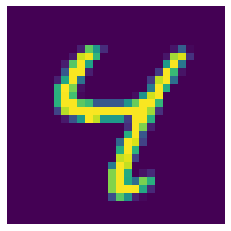

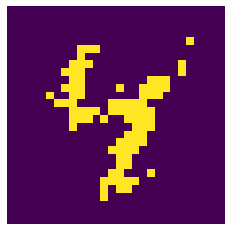

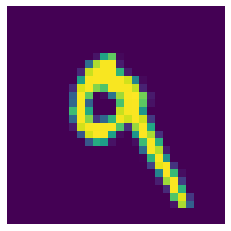

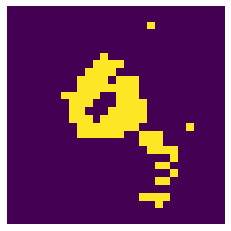

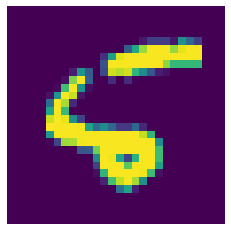

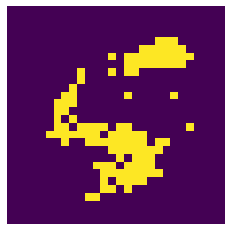

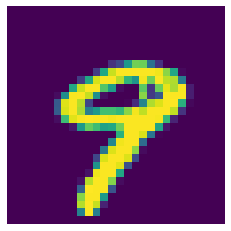

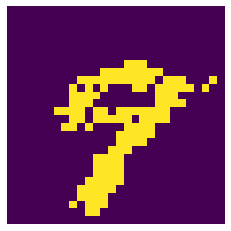

In [ ]:
for i in range(10):
    visualize_recontructions(test_imgs, i)

In [ ]:
hidden = [200,300,400,500]
all_loss = []

for h in hidden:
    print ("\nStarting a Restricted Boltzmann Machine..")

    rbm = RestrictedBoltzmannMachine(ndim_visible=image_size[0]*image_size[1],
                                        ndim_hidden=h,
                                        is_bottom=True,
                                        image_size=image_size,
                                        is_top=False,
                                        n_labels=10,
                                        batch_size=20
    )

    rbm.cd1(visible_trainset=train_imgs, n_iterations=4000)
    all_loss.append(rbm.rec_loss)


Starting a Restricted Boltzmann Machine..
learning CD1
iteration=      0 recon_loss=0.3168
iteration=    400 recon_loss=0.0636
iteration=    800 recon_loss=0.0526
iteration=   1200 recon_loss=0.0471
iteration=   1600 recon_loss=0.0440
iteration=   2000 recon_loss=0.0419
iteration=   2400 recon_loss=0.0394
iteration=   2800 recon_loss=0.0378
iteration=   3200 recon_loss=0.0368
iteration=   3600 recon_loss=0.0356

Starting a Restricted Boltzmann Machine..
learning CD1
iteration=      0 recon_loss=0.2983
iteration=    400 recon_loss=0.0595
iteration=    800 recon_loss=0.0485
iteration=   1200 recon_loss=0.0430
iteration=   1600 recon_loss=0.0400
iteration=   2000 recon_loss=0.0379
iteration=   2400 recon_loss=0.0355
iteration=   2800 recon_loss=0.0340
iteration=   3200 recon_loss=0.0331
iteration=   3600 recon_loss=0.0319

Starting a Restricted Boltzmann Machine..
learning CD1
iteration=      0 recon_loss=0.2816
iteration=    400 recon_loss=0.0566
iteration=    800 recon_loss=0.0457
iter

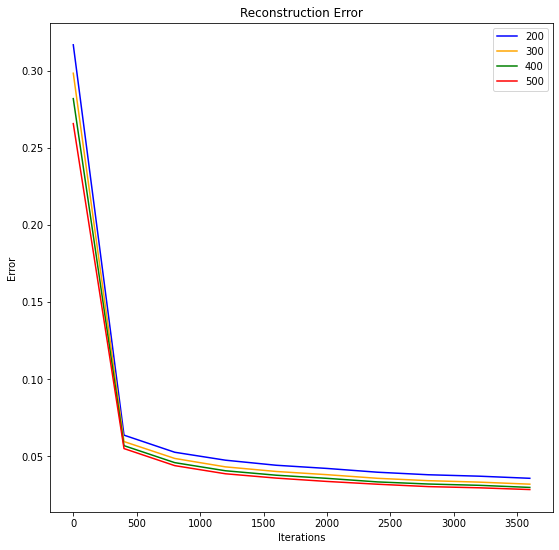

In [ ]:
color = ["blue", "orange", "green", "red"]

plt.figure(figsize=(9,9))

for i in range(0,len(hidden)):
    plt.plot(np.arange(0,3601,400), all_loss[i], c = color[i], label = hidden[i])
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("Reconstruction Error")
plt.legend()

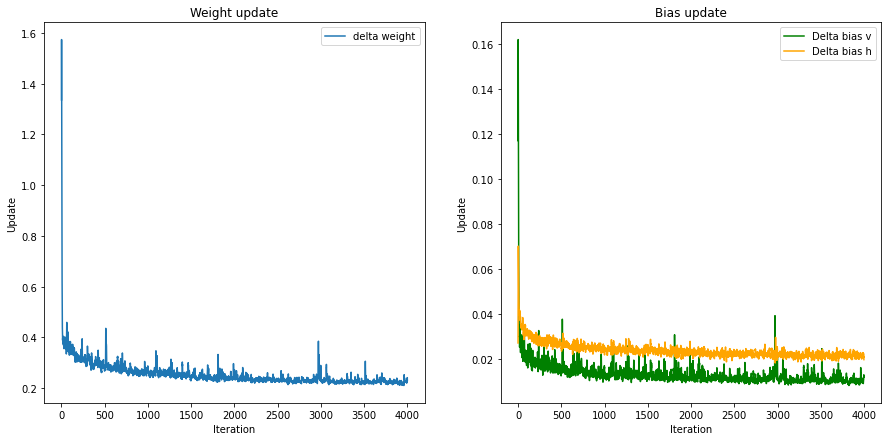

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.plot(rbm.delta_weight_vh_norm, label = "delta weight")
plt.xlabel('Iteration')
plt.ylabel('Update')
plt.title("Weight update")
plt.legend()

plt.subplot(122)
plt.plot(rbm.delta_bias_v_norm, label="Delta bias v", c = "green")
plt.plot(rbm.delta_bias_h_norm, label="Delta bias h", c = "orange")
plt.xlabel('Iteration')
plt.ylabel('Update')
plt.title("Bias update")
plt.legend()

plt.show()

Most certain correct: Guessed  4 with certainty 0.9999991847852421 actually was 4


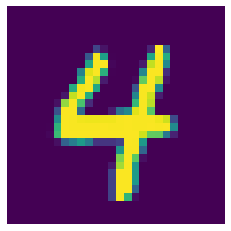

Least certain correct: Guessed  7 with certainty 0.3238512674064528 actually was 7


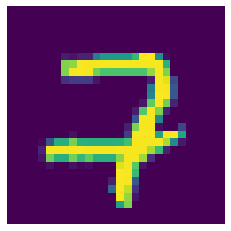

Most certain incorrect: Guessed  4 with certainty 0.9999477125596212 actually was 2


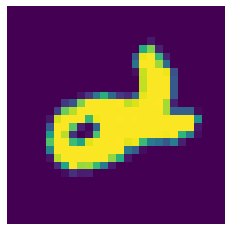

Least certain incorrect: Guessed  3 with certainty 0.3277534621258948 actually was 2


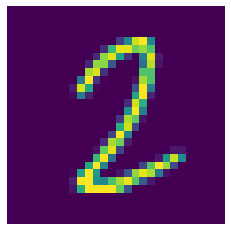

Most certain correct: Guessed  4 with certainty 0.99999982404527 actually was 4


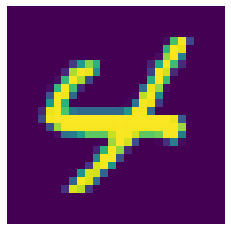

Least certain correct: Guessed  2 with certainty 0.29850298384332086 actually was 2


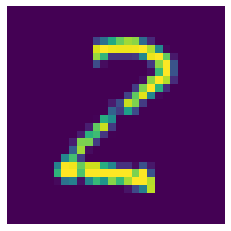

Most certain incorrect: Guessed  2 with certainty 0.9999080042697117 actually was 3


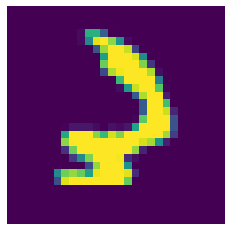

Least certain incorrect: Guessed  4 with certainty 0.24537843795001993 actually was 2


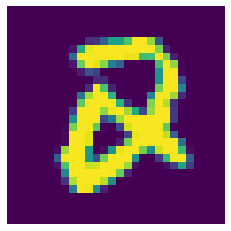

In [ ]:
#Finds the surest guess that was correct and incorrect
def printBestAndWorst(imgs,pred_lbls,true_lbls):
    """
        imgs: (n_images, image_size)
        pred_lbls: (n_images, n_labels)
    """
    n=pred_lbls.shape[0]
    assert n==imgs.shape[0] and n==true_lbls.shape[0]

    ind_correct=np.arange(n)[np.argmax(pred_lbls,axis=1)==np.argmax(true_lbls,axis=1)]
    ind_incorrect=np.arange(n)[np.argmax(pred_lbls,axis=1)!=np.argmax(true_lbls,axis=1)]

    most_certainty_ind=np.argmax(pred_lbls,axis=1)
    most_certainty=np.max(pred_lbls, axis=1)

    #Prints most certain correct
    ind_most_certain_correct = np.argmax(most_certainty[ind_correct])
    most_certain_correct=most_certainty[ind_correct[ind_most_certain_correct]]
    lbl_true=np.argmax(true_lbls[ind_correct[ind_most_certain_correct]])
    lbl_pred=np.argmax(pred_lbls[ind_correct[ind_most_certain_correct]])
    img=imgs[ind_correct[ind_most_certain_correct]]

    print("Most certain correct: Guessed ", lbl_pred, "with certainty", most_certain_correct, "actually was", lbl_true)

    plt.imshow(img.reshape((image_size[0], image_size[1])))
    plt.grid(False)
    plt.axis('off')
    plt.show()

    #Print least certain correct
    ind_least_certain_correct = np.argmin(most_certainty[ind_correct])
    least_certain_correct=most_certainty[ind_correct[ind_least_certain_correct]]
    lbl_true=np.argmax(true_lbls[ind_correct[ind_least_certain_correct]])
    lbl_pred=np.argmax(pred_lbls[ind_correct[ind_least_certain_correct]])
    img=imgs[ind_correct[ind_least_certain_correct]]

    print("Least certain correct: Guessed ", lbl_pred, "with certainty", least_certain_correct, "actually was", lbl_true)

    plt.imshow(img.reshape((image_size[0], image_size[1])))
    plt.grid(False)
    plt.axis('off')
    plt.show()

    #Prints most certain incorrect
    ind_most_certain_incorrect = np.argmax(most_certainty[ind_incorrect])
    most_certain_incorrect=most_certainty[ind_incorrect[ind_most_certain_incorrect]]
    lbl_true=np.argmax(true_lbls[ind_incorrect[ind_most_certain_incorrect]])
    lbl_pred=np.argmax(pred_lbls[ind_incorrect[ind_most_certain_incorrect]])
    img=imgs[ind_incorrect[ind_most_certain_incorrect]]

    print("Most certain incorrect: Guessed ", lbl_pred, "with certainty", most_certain_incorrect, "actually was", lbl_true)

    plt.imshow(img.reshape((image_size[0], image_size[1])))
    plt.grid(False)
    plt.axis('off')
    plt.show()

    #Print least certain incorrect
    ind_least_certain_incorrect = np.argmin(most_certainty[ind_incorrect])
    least_certain_incorrect=most_certainty[ind_incorrect[ind_least_certain_incorrect]]
    lbl_true=np.argmax(true_lbls[ind_incorrect[ind_least_certain_incorrect]])
    lbl_pred=np.argmax(pred_lbls[ind_incorrect[ind_least_certain_incorrect]])
    img=imgs[ind_incorrect[ind_least_certain_incorrect]]

    print("Least certain incorrect: Guessed ", lbl_pred, "with certainty", least_certain_incorrect, "actually was", lbl_true)

    plt.imshow(img.reshape((image_size[0], image_size[1])))
    plt.grid(False)
    plt.axis('off')
    plt.show()

printBestAndWorst(test_imgs, pred_lbls_test, test_lbls)
printBestAndWorst(train_imgs, pred_lbls_train, train_lbls)
